# 3. Pix2Pix 또는 CycleGAN 을 실습코드에 나온 데이터셋이 아닌 다른 데이터셋으로 학습시켜보기.
  - tfds모듈에서 제공하는 apple2orange 데이터셋을 활용해도 됨.
  - 데이터셋 추출예: dataset, metadata = tfds.load('cycle_gan/apple2orange',with_info=True, as_supervised=True)

## Set up the input pipeline

In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-4sj6o_w1
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-4sj6o_w1
  Created wheel for tensorflow-examples: filename=tensorflow_examples-55fcbdbe8578e7fa585c2a83d557cf759fa19d0f_-py3-none-any.whl size=270996 sha256=bf3ec40f965e90e1fedd92c7aca92e55af94050eee1f07dff2315bf3d06de888
  Stored in directory: /tmp/pip-ephem-wheel-cache-_ltbt3kj/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


## Import

In [2]:
import os
import time

from IPython.display import clear_output

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

AUTOTUNE = tf.data.AUTOTUNE

## 데이터셋 다운로드

In [3]:
dataset, metadata = tfds.load('cycle_gan/apple2orange',with_info=True, as_supervised=True)

train_apples, train_oranges = dataset['trainA'], dataset['trainB']
test_apples, test_oranges = dataset['testA'], dataset['testB']

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incomplete39C2OI/cycle_gan-trainA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incomplete39C2OI/cycle_gan-trainB.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incomplete39C2OI/cycle_gan-testA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incomplete39C2OI/cycle_gan-testB.tfrecord


Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0. Subsequent calls will reuse this data.


## 기초 함수 + 기본 파라미터

In [4]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [5]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [6]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [7]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [8]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [9]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

## 데이터셋 준비

In [10]:
train_apples = train_apples.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_oranges = train_oranges.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_apples = test_apples.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_oranges = test_oranges.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

In [11]:
sample_apple = next(iter(train_apples))
sample_orange = next(iter(train_oranges))

### 입력 데이터셋 확인

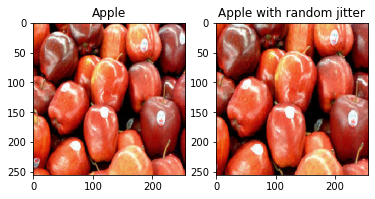

In [12]:
plt.subplot(121)
plt.title('Apple')
plt.imshow(sample_apple[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Apple with random jitter')
plt.imshow(random_jitter(sample_apple[0]) * 0.5 + 0.5)

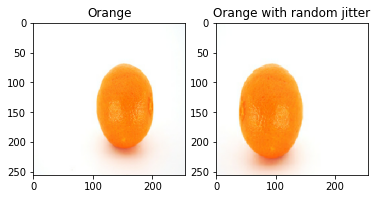

In [13]:
plt.subplot(121)
plt.title('Orange')
plt.imshow(sample_orange[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Orange with random jitter')
plt.imshow(random_jitter(sample_orange[0]) * 0.5 + 0.5)

## 모델 생성

In [15]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm') # Apple -> Orange
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm') # Orange -> Apple

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False) # Orange Disciminator
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False) # Apple Discriminator

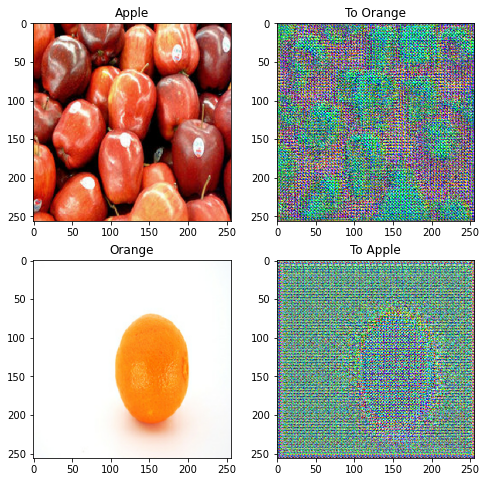

In [16]:
to_orange = generator_g(sample_apple)
to_apple = generator_f(sample_orange)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_apple, to_orange, sample_orange, to_apple]
title = ['Apple', 'To Orange', 'Orange', 'To Apple']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

### 초기 상태

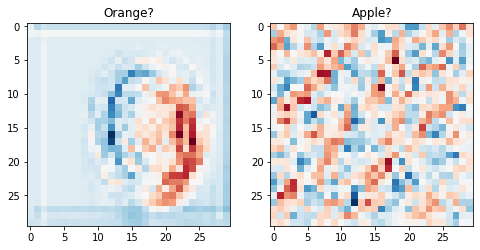

In [17]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Orange?')
plt.imshow(discriminator_y(sample_orange)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Apple?')
plt.imshow(discriminator_x(sample_apple)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss

In [18]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### 판별 모델 Loss

In [19]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

### 생성 모델 Loss

In [20]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

### Cycle Loss

In [21]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

### Identity Loss

In [22]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

## Optimizer

In [23]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## 중간 저장

In [24]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## 학습

In [25]:
EPOCHS = 40

def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [26]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

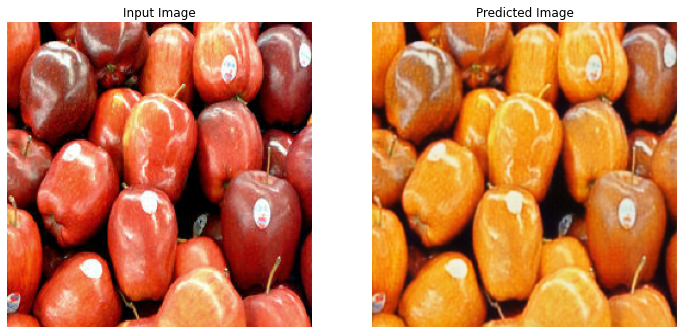

Saving checkpoint for epoch 15 at ./checkpoints/train/ckpt-3
Time taken for epoch 15 is 781.1033098697662 sec

............................................................................

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f4b6fa0a320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


KeyboardInterrupt: ignored

In [27]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_apples, train_oranges)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  
  generate_images(generator_g, sample_apple)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [31]:
!ls -al checkpoints/train/

total 4020840
drwxr-xr-x 2 root root       4096 Aug 12 10:18 .
drwxr-xr-x 3 root root       4096 Aug 12 08:08 ..
-rw-r--r-- 1 root root        343 Aug 12 10:18 checkpoint
-rw-r--r-- 1 root root 1372403676 Aug 12 08:08 ckpt-1.data-00000-of-00001
-rw-r--r-- 1 root root      28680 Aug 12 08:08 ckpt-1.index
-rw-r--r-- 1 root root 1372403676 Aug 12 09:13 ckpt-2.data-00000-of-00001
-rw-r--r-- 1 root root      28680 Aug 12 09:13 ckpt-2.index
-rw-r--r-- 1 root root 1372403676 Aug 12 10:18 ckpt-3.data-00000-of-00001
-rw-r--r-- 1 root root      28680 Aug 12 10:18 ckpt-3.index


In [ ]:
from google.colab import files

files.download('checkpoints/train/ckpt-3.index')

files.download('checkpoints/train/ckpt-3.data-00000-of-00001')

## 결과물 생성

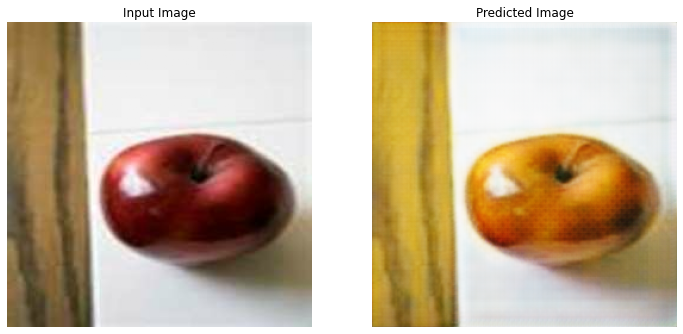

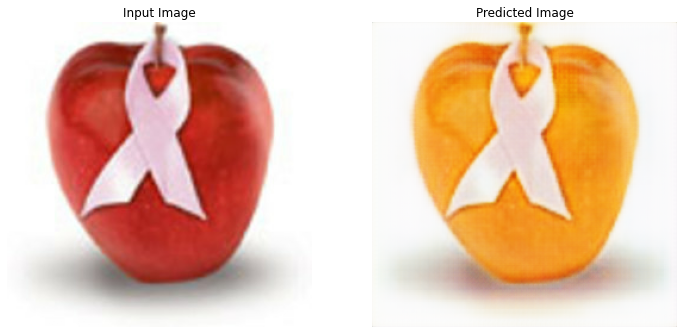

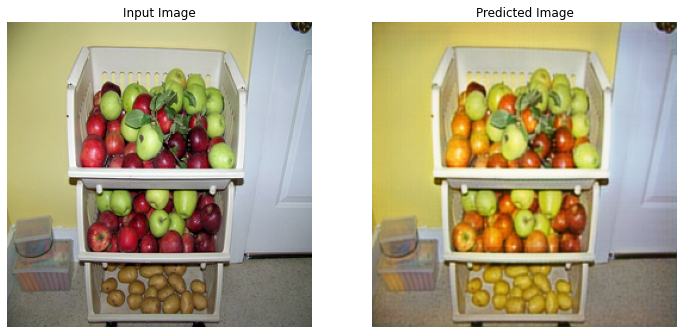

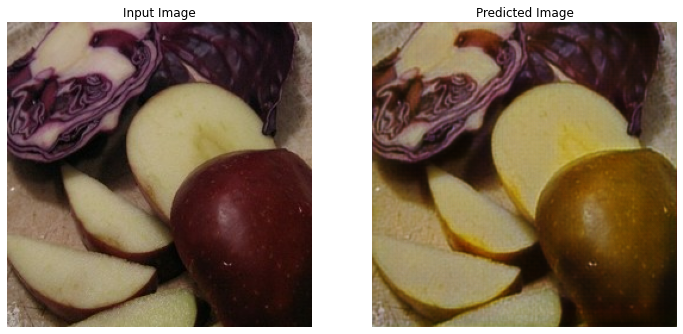

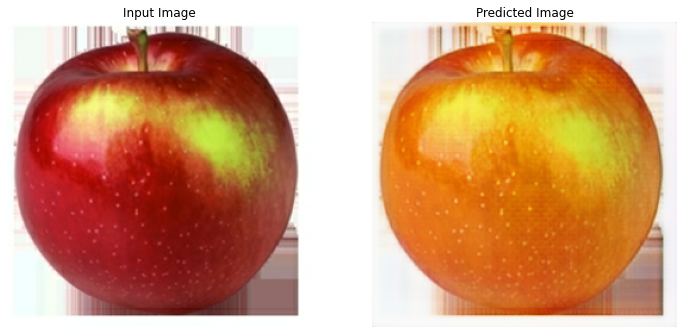

In [32]:
for inp in test_apples.take(5):
  generate_images(generator_g, inp)